## Predicting USD TRY's Monthly Changes - Pytorch LSTM LTC Example
### Applying LSTMs to Predict Monthly Changes

Required libraries are mentioned in the code description section!

In [1]:
#-- Necessary Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
df = pd.read_csv('USDTRY_Data.csv', index_col='Date')
#-- Using this we can select the amount of data to use, some of the very early years 
#- aren't formatted properly and will throw an error
df=df.iloc[:50]
#-- Change the dates into a format that pandas will recognise
df.index = [df.index[i].split()[0]+" "+df.index[i].split()[2] for i in range(len(df.index))]
#-- Set index to correct format
df.index = pd.to_datetime(df.index)
#-- Put the data in chronological order
df = df.iloc[::-1]
#-- Only select data up to end of 2019
df = df[:"2022"]
#-- Remove the strings (standing for data separation) from the values and store as float rather than a string
df.Value = [float(df.Value[i][:-1]) for i in range(len(df.Value))]

In [3]:
def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test
test_periods = 8
train, test = train_test(df, test_periods)

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [5]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([35, 1])
Correct dimensions : torch.Size([35])


In [6]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 16 #-- number of quarters for input
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([11, 16])
torch.Size([11, 8])


In [7]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as date, first data, variables, output
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), 
                                          self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [8]:
model = LSTM(input_size=1, hidden_size=50, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 600
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.45157272
epoch:  100 loss:0.00702001
epoch:  200 loss:0.00115486
epoch:  300 loss:0.00066094
epoch:  400 loss:0.00052264
epoch:  500 loss:0.00048030
epoch:  600 loss:0.00065954


In [10]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-train_periods:], None)
#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))

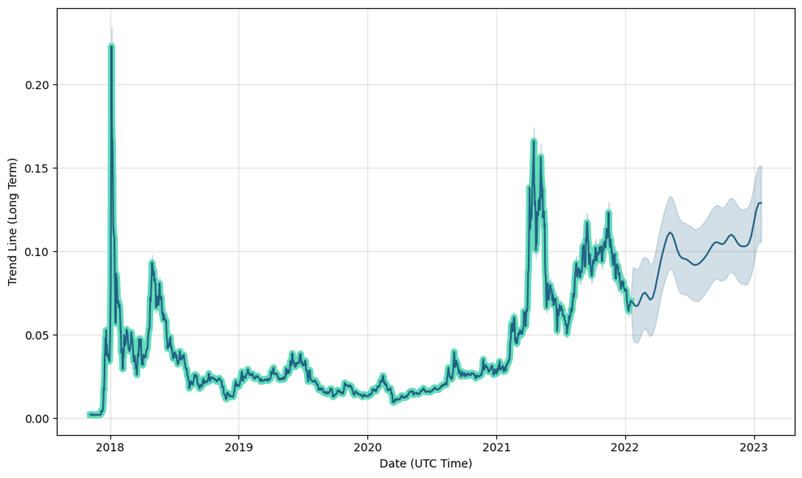

In [12]:
x = [dt.datetime.date(d) for d in df.index]
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('USD TRY Changes')
plt.ylabel('Revenue (Points)')
plt.grid(True)
plt.plot(x[:-len(predictions)],
         df.Value[:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         df.Value[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)